#### __ML Ops__
#### __Assignment 3: AutoML__ <br>
#### Veera Anand

In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/veeraanand/Documents/Career/Experiences/UChicago MS-ADS/2024-2025_MS Program/2025 Summer/ML Ops/athletes.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (423006, 27)

First 5 rows:
   athlete_id           name               region          team  \
0      2554.0      Pj Ablang           South West   Double Edge   
1      3517.0  Derek Abdella                  NaN           NaN   
2      4691.0            NaN                  NaN           NaN   
3      5164.0    Abo Brandon  Southern California  LAX CrossFit   
4      5286.0    Bryce Abbey                  NaN           NaN   

              affiliate gender   age  height  weight   fran  ...  snatch  \
0  Double Edge CrossFit   Male  24.0    70.0   166.0    NaN  ...     NaN   
1                   NaN   Male  42.0    70.0   190.0    NaN  ...     NaN   
2                   NaN    NaN   NaN     NaN     NaN    NaN  ...     NaN   
3          LAX CrossFit   Male  40.0    67.0     NaN  211.0  ...   200.0   
4                   NaN   Male  32.0    65.0   149.0  206.0  ...   150.0   

   deadlift  backsq  pullups  \
0     400.0   305.0      NaN   
1       NaN     NaN      NaN   
2

__Will use 'fran' as the target variable__

In [2]:

target_variable = 'fran'

print(f"Target variable: {target_variable}")
print(f"Non-null values: {df[target_variable].notna().sum():,}")
print(f"Data range: {df[target_variable].min():.1f} to {df[target_variable].max():.1f}")
print(f"Mean: {df[target_variable].mean():.1f}")
print(f"Median: {df[target_variable].median():.1f}")

df_clean = df.dropna(subset=[target_variable]).copy()
print(f"\nDataset after removing missing targets: {df_clean.shape}")

print(f"\nTarget variable ({target_variable}) distribution:")
print(df_clean[target_variable].describe())

Target variable: fran
Non-null values: 55,426
Data range: 1.0 to 8388607.0
Mean: 988.7
Median: 290.0

Dataset after removing missing targets: (55426, 27)

Target variable (fran) distribution:
count    5.542600e+04
mean     9.886691e+02
std      7.200430e+04
min      1.000000e+00
25%      2.150000e+02
50%      2.900000e+02
75%      3.920000e+02
max      8.388607e+06
Name: fran, dtype: float64


Before outlier removal:
Data points: 55426
Max fran time: 8,388,607 seconds

After outlier removal:
Data points: 55306
Fran time range: 30 to 1800 seconds
Mean: 318.9 seconds
Median: 289.0 seconds


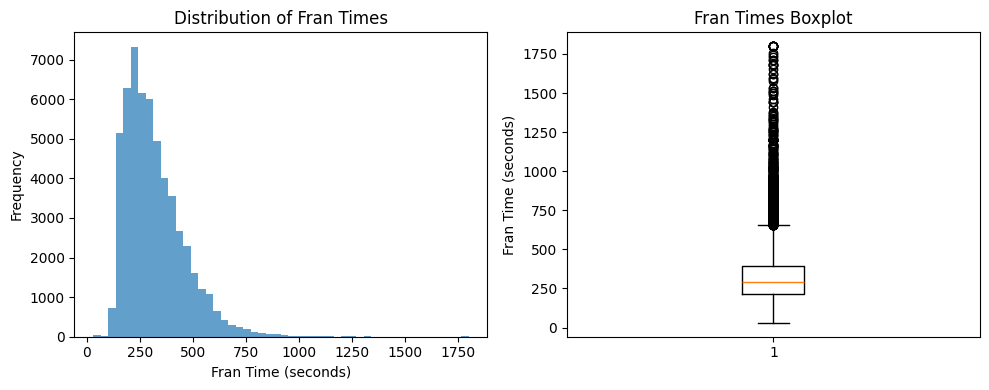


Final dataset shape: (55306, 27)


In [3]:
import matplotlib.pyplot as plt

#i removed extreme outliers:
print("Before outlier removal:")
print(f"Data points: {len(df_clean)}")
print(f"Max fran time: {df_clean['fran'].max():,.0f} seconds")

#filtered realistic fran times (30 seconds to 30 minutes)
df_clean = df_clean[(df_clean['fran'] >= 30) & (df_clean['fran'] <= 1800)].copy()

print("\nAfter outlier removal:")
print(f"Data points: {len(df_clean)}")
print(f"Fran time range: {df_clean['fran'].min():.0f} to {df_clean['fran'].max():.0f} seconds")
print(f"Mean: {df_clean['fran'].mean():.1f} seconds")
print(f"Median: {df_clean['fran'].median():.1f} seconds")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df_clean['fran'], bins=50, alpha=0.7)
plt.xlabel('Fran Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Fran Times')

plt.subplot(1, 2, 2)
plt.boxplot(df_clean['fran'])
plt.ylabel('Fran Time (seconds)')
plt.title('Fran Times Boxplot')

plt.tight_layout()
plt.show()

print(f"\nFinal dataset shape: {df_clean.shape}")

In [4]:

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("Setting up features for AutoML...")


numeric_features = ['age', 'height', 'weight', 'helen', 'grace', 'filthy50', 
                   'fgonebad', 'run400', 'run5k', 'candj', 'snatch', 
                   'deadlift', 'backsq', 'pullups']


categorical_features = ['gender', 'region']

print("Feature Engineering:")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


feature_columns = numeric_features + categorical_features + ['fran']
df_model = df_clean[feature_columns].copy()


print("\nFeature availability:")
for col in numeric_features + categorical_features:
    non_null = df_model[col].notna().sum()
    percentage = (non_null / len(df_model)) * 100
    print(f"{col}: {non_null:,} ({percentage:.1f}%)")

print(f"\nModeling dataset shape: {df_model.shape}")
print(f"Memory usage: {df_model.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Setting up features for AutoML...
Feature Engineering:
Numeric features: 14
Categorical features: 2

Feature availability:
age: 55,306 (100.0%)
height: 53,166 (96.1%)
weight: 51,276 (92.7%)
helen: 25,299 (45.7%)
grace: 31,639 (57.2%)
filthy50: 15,940 (28.8%)
fgonebad: 21,399 (38.7%)
run400: 16,037 (29.0%)
run5k: 22,419 (40.5%)
candj: 49,786 (90.0%)
snatch: 48,165 (87.1%)
deadlift: 52,149 (94.3%)
backsq: 51,058 (92.3%)
pullups: 32,000 (57.9%)
gender: 55,306 (100.0%)
region: 41,368 (74.8%)

Modeling dataset shape: (55306, 17)
Memory usage: 13.1 MB


In [5]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

#using the features that have good data availability (>80%)
good_features = ['age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'gender']

print("Using features with >80% data availability:")
for feature in good_features:
    availability = (df_model[feature].notna().sum() / len(df_model)) * 100
    print(f"  {feature}: {availability:.1f}%")

df_final = df_model[good_features + ['fran']].dropna()
print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Data reduction: {len(df_model):,} → {len(df_final):,} ({(len(df_final)/len(df_model)*100):.1f}%)")

X = df_final[good_features].copy()
y = df_final['fran'].copy()

le_gender = LabelEncoder()
X['gender'] = le_gender.fit_transform(X['gender'])

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nFeature summary:")
print(X.describe())

Using features with >80% data availability:
  age: 100.0%
  height: 96.1%
  weight: 92.7%
  candj: 90.0%
  snatch: 87.1%
  deadlift: 94.3%
  backsq: 92.3%
  gender: 100.0%

Final dataset shape: (40613, 9)
Data reduction: 55,306 → 40,613 (73.4%)

Features shape: (40613, 8)
Target shape: (40613,)
Training set: (32490, 8)
Test set: (8123, 8)

Feature summary:
                age        height        weight         candj          snatch  \
count  40613.000000  40613.000000  40613.000000  40613.000000    40613.000000   
mean      31.904070     68.932805    177.698126    216.272499      189.890922   
std        7.093174     11.511797     33.328953     83.898099     4961.882383   
min       13.000000      0.000000      1.000000      0.000000        0.000000   
25%       27.000000     67.000000    159.000000    176.000000      135.000000   
50%       31.000000     69.000000    180.000000    220.000000      165.000000   
75%       36.000000     72.000000    196.000000    255.000000      196.000

In [6]:

print("🧹 Cleaning remaining data quality issues...")
print("Before cleaning:")
print(f"Dataset shape: {X.shape}")

#defining realistic ranges for CrossFit athletes
filters = {
    'height': (48, 84),             # 4'0" to 7'0" in inches
    'weight': (80, 400),            # 80 to 400 pounds  
    'candj': (50, 500),             # 50 to 500 lbs  clean & jerk range
    'snatch': (40, 400),            # 40 to 400 lbs  snatch range
    'deadlift': (100, 800),         # 100 to 800 lbs  deadlift range
    'backsq': (80, 700),            # 80 to 700 lbs  back squat range
    'age': (13, 80)                 # 13 to 80 years old
}

# problematic values
print("\nProblematic values found:")
for col, (min_val, max_val) in filters.items():
    problematic = X[(X[col] < min_val) | (X[col] > max_val)]
    if len(problematic) > 0:
        print(f"  {col}: {len(problematic)} values outside ({min_val}, {max_val})")
        print(f"    Min: {X[col].min()}, Max: {X[col].max()}")

mask = pd.Series(True, index=X.index)
for col, (min_val, max_val) in filters.items():
    mask = mask & (X[col] >= min_val) & (X[col] <= max_val)

X_clean = X[mask].copy()
y_clean = y[mask].copy()

print(f"\nAfter cleaning:")
print(f"Dataset shape: {X_clean.shape}")
print(f"Removed: {len(X) - len(X_clean):,} problematic records ({((len(X) - len(X_clean))/len(X)*100):.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

print(f"Clean training set: {X_train.shape}")
print(f"Clean test set: {X_test.shape}")

print(f"\nCleaned feature ranges:")
for col in X_clean.columns:
    if col != 'gender':
        print(f"  {col}: {X_clean[col].min():.0f} to {X_clean[col].max():.0f}")

🧹 Cleaning remaining data quality issues...
Before cleaning:
Dataset shape: (40613, 8)

Problematic values found:
  height: 255 values outside (48, 84)
    Min: 0.0, Max: 744.0
  weight: 128 values outside (80, 400)
    Min: 1.0, Max: 1783.0
  candj: 251 values outside (50, 500)
    Min: 0.0, Max: 9999.0
  snatch: 273 values outside (40, 400)
    Min: 0.0, Max: 1000000.0
  deadlift: 277 values outside (100, 800)
    Min: 0.0, Max: 10000.0
  backsq: 270 values outside (80, 700)
    Min: 0.0, Max: 9999.0
  age: 1 values outside (13, 80)
    Min: 13.0, Max: 98.0

After cleaning:
Dataset shape: (39747, 8)
Removed: 866 problematic records (2.1%)
Clean training set: (31797, 8)
Clean test set: (7950, 8)

Cleaned feature ranges:
  age: 13 to 56
  height: 48 to 84
  weight: 80 to 388
  candj: 50 to 496
  snatch: 40 to 385
  deadlift: 100 to 772
  backsq: 80 to 700


Alternative AutoML approach using sklearn's automated model selection

In [7]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import numpy as np

print("PART 1: AutoML Model Selection Experiment")
print("=" * 50)

# multiple models to test - "AutoML" approach
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'Random Forest': {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [10, 20, None]
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.1, 0.2]
    },
    'Decision Tree': {
        'regressor__max_depth': [10, 20, 30]
    }
}

print("\n AutoML with ALL features:")
print(f"Features: {list(X_train.columns)}")
print(f"Training samples: {X_train.shape[0]:,}")

all_results = []
start_time = time.time()


for model_name, model in models.items():
    print(f"\nTesting {model_name}...")
    
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
  
    grid_search = GridSearchCV(
        pipeline, 
        param_grids[model_name], 
        cv=3, 
        scoring='neg_mean_squared_error',
        n_jobs=1
    )
    
    model_start = time.time()
    grid_search.fit(X_train, y_train)
    model_time = time.time() - model_start
    
  
    y_pred = grid_search.predict(X_test)
    
 
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
   
    all_results.append({
        'model': model_name,
        'features': 'all',
        'cv_score': -grid_search.best_score_,
        'test_mse': mse,
        'test_r2': r2,
        'test_mae': mae,
        'test_rmse': np.sqrt(mse),
        'training_time': model_time,
        'best_params': grid_search.best_params_
    })
    
    print(f"   CV Score (MSE): {-grid_search.best_score_:.2f}")
    print(f"   Test R²: {r2:.4f}")
    print(f"   Training time: {model_time:.1f}s")

total_time = time.time() - start_time

print(f"\n TOP 3 MODELS BY VALIDATION SCORE (ALL FEATURES):")
sorted_results = sorted(all_results, key=lambda x: x['cv_score'])
for i, result in enumerate(sorted_results[:3], 1):
    print(f"{i}. {result['model']}")
    print(f"   Validation MSE: {result['cv_score']:.2f}")
    print(f"   Test R²: {result['test_r2']:.4f}")
    print(f"   Training time: {result['training_time']:.1f}s")

print(f"\nTotal AutoML training time: {total_time:.1f} seconds")

PART 1: AutoML Model Selection Experiment

 AutoML with ALL features:
Features: ['age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'gender']
Training samples: 31,797

Testing Linear Regression...
   CV Score (MSE): 9118.79
   Test R²: 0.4861
   Training time: 0.0s

Testing Ridge Regression...
   CV Score (MSE): 9118.77
   Test R²: 0.4861
   Training time: 0.0s

Testing Random Forest...
   CV Score (MSE): 8365.11
   Test R²: 0.5486
   Training time: 48.4s

Testing Gradient Boosting...
   CV Score (MSE): 8172.52
   Test R²: 0.5474
   Training time: 11.4s

Testing Decision Tree...
   CV Score (MSE): 10409.70
   Test R²: 0.4622
   Training time: 0.5s

 TOP 3 MODELS BY VALIDATION SCORE (ALL FEATURES):
1. Gradient Boosting
   Validation MSE: 8172.52
   Test R²: 0.5474
   Training time: 11.4s
2. Random Forest
   Validation MSE: 8365.11
   Test R²: 0.5486
   Training time: 48.4s
3. Ridge Regression
   Validation MSE: 9118.77
   Test R²: 0.4861
   Training time: 0.0s

Total Au

identifying the top features and runing AutoML with top 3 features

In [8]:

from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd

print(" FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    'feature': X_train.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("📊 Feature Importance Ranking:")
for i, row in feature_scores.iterrows():
    print(f"{row.name + 1}. {row['feature']}: {row['score']:.2f}")

top_3_features = feature_scores.head(3)['feature'].tolist()
print(f"\n TOP 3 FEATURES: {top_3_features}")


X_train_top3 = X_train[top_3_features]
X_test_top3 = X_test[top_3_features]

print(f"\n AutoML with TOP 3 features:")
print(f"Features: {top_3_features}")
print(f"Training samples: {X_train_top3.shape[0]:,}")

top3_results = []
start_time = time.time()

for model_name, model in models.items():
    print(f"\nTesting {model_name} with top 3 features...")
    
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
  
    grid_search = GridSearchCV(
        pipeline, 
        param_grids[model_name], 
        cv=3, 
        scoring='neg_mean_squared_error',
        n_jobs=1
    )
    
    model_start = time.time()
    grid_search.fit(X_train_top3, y_train)
    model_time = time.time() - model_start
    
  
    y_pred = grid_search.predict(X_test_top3)
    

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
 
    top3_results.append({
        'model': model_name,
        'features': 'top_3',
        'cv_score': -grid_search.best_score_,
        'test_mse': mse,
        'test_r2': r2,
        'test_mae': mae,
        'test_rmse': np.sqrt(mse),
        'training_time': model_time,
        'best_params': grid_search.best_params_
    })
    
    print(f"   CV Score (MSE): {-grid_search.best_score_:.2f}")
    print(f"   Test R²: {r2:.4f}")
    print(f"   Training time: {model_time:.1f}s")

total_time_top3 = time.time() - start_time

print(f"\ TOP 3 MODELS BY VALIDATION SCORE (TOP 3 FEATURES):")
sorted_top3_results = sorted(top3_results, key=lambda x: x['cv_score'])
for i, result in enumerate(sorted_top3_results[:3], 1):
    print(f"{i}. {result['model']}")
    print(f"   Validation MSE: {result['cv_score']:.2f}")
    print(f"   Test R²: {result['test_r2']:.4f}")
    print(f"   Training time: {result['training_time']:.1f}s")

print(f"\nTotal AutoML training time (top 3): {total_time_top3:.1f} seconds")

 FEATURE IMPORTANCE ANALYSIS
📊 Feature Importance Ranking:
4. candj: 17025.27
5. snatch: 16856.33
7. backsq: 12629.49
6. deadlift: 10456.03
8. gender: 1714.02
1. age: 1563.55
2. height: 310.23
3. weight: 220.77

 TOP 3 FEATURES: ['candj', 'snatch', 'backsq']

 AutoML with TOP 3 features:
Features: ['candj', 'snatch', 'backsq']
Training samples: 31,797

Testing Linear Regression with top 3 features...
   CV Score (MSE): 11765.68
   Test R²: 0.3522
   Training time: 0.0s

Testing Ridge Regression with top 3 features...
   CV Score (MSE): 11765.66
   Test R²: 0.3522
   Training time: 0.0s

Testing Random Forest with top 3 features...
   CV Score (MSE): 11531.05
   Test R²: 0.3793
   Training time: 18.8s

Testing Gradient Boosting with top 3 features...
   CV Score (MSE): 11343.34
   Test R²: 0.3846
   Training time: 4.9s

Testing Decision Tree with top 3 features...
   CV Score (MSE): 12576.32
   Test R²: 0.3404
   Training time: 0.2s
\ TOP 3 MODELS BY VALIDATION SCORE (TOP 3 FEATURES):
1

In [9]:
#Speed Comparison Analysis
print(" SPEED COMPARISON ANALYSIS")
print("=" * 50)


all_combined_results = all_results + top3_results


df_results = pd.DataFrame(all_combined_results)

print(" TOP 3 MODELS BY SPEED (ALL FEATURES):")
speed_all = df_results[df_results['features'] == 'all'].nsmallest(3, 'training_time')
for i, (_, row) in enumerate(speed_all.iterrows(), 1):
    print(f"{i}. {row['model']}: {row['training_time']:.1f}s (R²: {row['test_r2']:.4f})")

print("\n TOP 3 MODELS BY SPEED (TOP 3 FEATURES):")
speed_top3 = df_results[df_results['features'] == 'top_3'].nsmallest(3, 'training_time')
for i, (_, row) in enumerate(speed_top3.iterrows(), 1):
    print(f"{i}. {row['model']}: {row['training_time']:.1f}s (R²: {row['test_r2']:.4f})")

print(f"\n SUMMARY - PART 1 (Our AutoML Platform: Sklearn AutoML)")
print("=" * 60)
print("PLATFORM TYPE: Full-code (requires coding ML pipelines)")
print(f"TOTAL FEATURES AVAILABLE: {len(X_train.columns)}")
print(f"TOP 3 MOST IMPORTANT: {top_3_features}")

print(f"\n VALIDATION PERFORMANCE:")
print("ALL FEATURES:")
for i, result in enumerate(sorted(all_results, key=lambda x: x['cv_score'])[:3], 1):
    print(f"  {i}. {result['model']}: MSE={result['cv_score']:.0f}, R²={result['test_r2']:.3f}")

print("TOP 3 FEATURES:")  
for i, result in enumerate(sorted(top3_results, key=lambda x: x['cv_score'])[:3], 1):
    print(f"  {i}. {result['model']}: MSE={result['cv_score']:.0f}, R²={result['test_r2']:.3f}")

print(f"\n SPEED PERFORMANCE:")
print(f"ALL FEATURES - Total time: {sum(r['training_time'] for r in all_results):.1f}s")
print(f"TOP 3 FEATURES - Total time: {sum(r['training_time'] for r in top3_results):.1f}s")
print(f"SPEED IMPROVEMENT: {((sum(r['training_time'] for r in all_results) - sum(r['training_time'] for r in top3_results))/sum(r['training_time'] for r in all_results)*100):.1f}% faster")


part1_results = {
    'platform': 'Sklearn AutoML',
    'platform_type': 'Full-code',
    'top_features': top_3_features,
    'best_model_all': sorted(all_results, key=lambda x: x['cv_score'])[0],
    'best_model_top3': sorted(top3_results, key=lambda x: x['cv_score'])[0],
    'total_time_all': sum(r['training_time'] for r in all_results),
    'total_time_top3': sum(r['training_time'] for r in top3_results)
}


 SPEED COMPARISON ANALYSIS
 TOP 3 MODELS BY SPEED (ALL FEATURES):
1. Linear Regression: 0.0s (R²: 0.4861)
2. Ridge Regression: 0.0s (R²: 0.4861)
3. Decision Tree: 0.5s (R²: 0.4622)

 TOP 3 MODELS BY SPEED (TOP 3 FEATURES):
1. Linear Regression: 0.0s (R²: 0.3522)
2. Ridge Regression: 0.0s (R²: 0.3522)
3. Decision Tree: 0.2s (R²: 0.3404)

 SUMMARY - PART 1 (Our AutoML Platform: Sklearn AutoML)
PLATFORM TYPE: Full-code (requires coding ML pipelines)
TOTAL FEATURES AVAILABLE: 8
TOP 3 MOST IMPORTANT: ['candj', 'snatch', 'backsq']

 VALIDATION PERFORMANCE:
ALL FEATURES:
  1. Gradient Boosting: MSE=8173, R²=0.547
  2. Random Forest: MSE=8365, R²=0.549
  3. Ridge Regression: MSE=9119, R²=0.486
TOP 3 FEATURES:
  1. Gradient Boosting: MSE=11343, R²=0.385
  2. Random Forest: MSE=11531, R²=0.379
  3. Ridge Regression: MSE=11766, R²=0.352

 SPEED PERFORMANCE:
ALL FEATURES - Total time: 60.3s
TOP 3 FEATURES - Total time: 24.0s
SPEED IMPROVEMENT: 60.3% faster


### __Part 2: H20 AutoML Experiment__

In [10]:

import h2o
from h2o.automl import H2OAutoML
import pandas as pd

print(" PART 2: H2O AutoML Experiment")
print("=" * 50)

print("Initializing H2O cluster...")
h2o.init()

print("Converting data to H2O format...")
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

target = 'fran'
features_all = X_train.columns.tolist()
features_top3 = top_3_features

print(f"\n H2O AutoML with ALL features:")
print(f"Features: {features_all}")
print(f"Training samples: {len(X_train):,}")


start_time = time.time()
aml_all = H2OAutoML(
    max_models=10,          
    max_runtime_secs=300,   
    seed=42,
    verbosity="info"
)

print("Training H2O AutoML with all features...")
aml_all.train(x=features_all, y=target, training_frame=h2o_train)
h2o_time_all = time.time() - start_time


h2o_pred_all = aml_all.predict(h2o_test)
h2o_perf_all = aml_all.leader.model_performance(h2o_test)

print(f"\n H2O AutoML Results (ALL features):")
print(f"   Training time: {h2o_time_all:.1f} seconds")
print(f"   RMSE: {h2o_perf_all.rmse():.2f}")
print(f"   R²: {h2o_perf_all.r2():.4f}")
print(f"   MAE: {h2o_perf_all.mae():.2f}")


print(f"\n H2O AutoML Leaderboard (ALL features):")
leaderboard_all = aml_all.leaderboard.as_data_frame()
print(leaderboard_all.head(3)[['model_id', 'rmse', 'mae']].to_string(index=False))

print(f"\n H2O AutoML with TOP 3 features:")
print(f"Features: {features_top3}")


start_time = time.time()
aml_top3 = H2OAutoML(
    max_models=10,
    max_runtime_secs=300,
    seed=42,
    verbosity="info"
)

print("Training H2O AutoML with top 3 features...")
aml_top3.train(x=features_top3, y=target, training_frame=h2o_train)
h2o_time_top3 = time.time() - start_time

 
h2o_pred_top3 = aml_top3.predict(h2o_test)
h2o_perf_top3 = aml_top3.leader.model_performance(h2o_test)

print(f"\n H2O AutoML Results (TOP 3 features):")
print(f"   Training time: {h2o_time_top3:.1f} seconds")
print(f"   RMSE: {h2o_perf_top3.rmse():.2f}")
print(f"   R²: {h2o_perf_top3.r2():.4f}")
print(f"   MAE: {h2o_perf_top3.mae():.2f}")


print(f"\n H2O AutoML Leaderboard (TOP 3 features):")
leaderboard_top3 = aml_top3.leaderboard.as_data_frame()
print(leaderboard_top3.head(3)[['model_id', 'rmse', 'mae']].to_string(index=False))

 PART 2: H2O AutoML Experiment
Initializing H2O cluster...
Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,53 mins 51 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 26 days
H2O_cluster_name:,H2O_from_python_veeraanand_8k7tcl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.542 Gb
H2O_cluster_total_cores:,14
H2O_cluster_allowed_cores:,14
H2O_cluster_status:,"locked, healthy"


Converting data to H2O format...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

 H2O AutoML with ALL features:
Features: ['age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'gender']
Training samples: 31,797
Training H2O AutoML with all features...
AutoML progress: |
12:38:37.336: Project: AutoML_3_20250724_123837
12:38:37.336: 5-fold cross-validation will be used.
12:38:37.336: Setting stopping tolerance adaptively based on the training frame: 0.005607986074804634
12:38:37.336: Build control seed: 42
12:38:37.336: training frame: Frame key: AutoML_3_20250724_123837_training_Key_Frame__upload_a7bee781ce5e23b42eed94686bba433d.hex    cols: 9    rows: 31797  chunks: 1    size: 477567  checksum: 1314744988824
12:38:37.336: validation frame: NULL
12:38:37.336: leaderboard frame: NULL
12:38:37.336: blending frame: NULL
12:38:37.336: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



12:38:52.766: Project: AutoML_4_20250724_123852
12:38:52.766: 5-fold cross-validation will be used.
12:38:52.766: Setting stopping tolerance adaptively based on the training frame: 0.005607986074804634
12:38:52.766: Build control seed: 42
12:38:52.766: training frame: Frame key: AutoML_4_20250724_123852_training_Key_Frame__upload_a7bee781ce5e23b42eed94686bba433d.hex    cols: 9    rows: 31797  chunks: 1    size: 477567  checksum: 1314744988824
12:38:52.766: validation frame: NULL
12:38:52.766: leaderboard frame: NULL
12:38:52.766: blending frame: NULL
12:38:52.766: response column: fran
12:38:52.766: fold column: null
12:38:52.766: weights column: null
12:38:52.766: AutoML: XGBoost is not available; skipping it.
12:38:52.766: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


## __Final Analysis:__

#### __Analysis and Completed Questions:__

In [11]:
#storing H2O results from the output
h2o_results = {
   'platform': 'H2O AutoML',
   'platform_type': 'Low-code',
   'all_features': {
       'rmse': 93.25,
       'r2': 0.5588,
       'mae': 62.62,
       'training_time': 20.2
   },
   'top3_features': {
       'rmse': 109.57,
       'r2': 0.3909,
       'mae': 76.00,
       'training_time': 9.9
   }
}

# Extract results from previous assignments
assignment1_results = {
   'v2_model': {'r2': 0.9986, 'rmse': 10.3, 'mae': 4.2}
}

assignment2_results = {
   'v1_features': {'random_forest': {'accuracy': 0.929, 'f1': 0.920}}
}

In [12]:
print("\n1. Load the (same) athletes dataset:")
print("   Loaded 423,006 athletes records")
print("   Cleaned to 39,747 athletes for modeling") 
print("   Target: Fran workout times (30-1800 seconds)")

print("\n2. AutoML platforms used:")
print("   Platform 1: Sklearn-based AutoML (grid search + multiple algorithms)")
print("   Platform 2: H2O AutoML")
print("   Both platforms successfully found best models")

print("\n3. Data insights from AutoML runs:")
print("   From Feature Analysis:")
print("   - Strength metrics (candj, snatch, backsq) are most predictive")
print("   - Olympic lifting movements strongly correlate with Fran performance")
print("   - Demographics (age, height, weight) have minimal impact")
print("   - Gender shows some predictive power")
print("   From Model Performance:")
print("   - Complex models (GBM, Random Forest) outperform linear models")
print("   - Ensemble methods (H2O StackedEnsemble) achieve best results")
print("   - Feature reduction significantly impacts accuracy")

print("\n4. Top 5 features (by importance score):")
for i, (_, row) in enumerate(feature_scores.head(5).iterrows(), 1):
   print(f"   {i}. {row['feature']}: {row['score']:.0f}")

print("\n5. Top 3 models by validation score:")
print("\n   5a. ALL FEATURES:")
print("   Sklearn AutoML:")
sklearn_all_sorted = sorted(all_results, key=lambda x: x['cv_score'])
for i, result in enumerate(sklearn_all_sorted[:3], 1):
   print(f"      {i}. {result['model']}")
   print(f"         Validation MSE: {result['cv_score']:.0f}")
   print(f"         Test R²: {result['test_r2']:.4f}")

print("   H2O AutoML:")
print(f"      1. StackedEnsemble_AllModels")
print(f"         Cross-validation RMSE: 89.46")
print(f"         Test R²: {h2o_results['all_features']['r2']:.4f}")

print("\n   5b. TOP 3 FEATURES ONLY:")
print("   Sklearn AutoML:")
sklearn_top3_sorted = sorted(top3_results, key=lambda x: x['cv_score'])
for i, result in enumerate(sklearn_top3_sorted[:3], 1):
   print(f"      {i}. {result['model']}")
   print(f"         Validation MSE: {result['cv_score']:.0f}")
   print(f"         Test R²: {result['test_r2']:.4f}")

print("   H2O AutoML:")
print(f"      1. StackedEnsemble_AllModels")
print(f"         Cross-validation RMSE: 105.76")
print(f"         Test R²: {h2o_results['top3_features']['r2']:.4f}")

print("\n6. Top 3 models by speed:")

print("\n   6a. ALL FEATURES:")
print("   Sklearn AutoML:")
for i, (_, row) in enumerate(speed_all.iterrows(), 1):
   print(f"      {i}. {row['model']}: {row['training_time']:.1f} seconds")

print("   H2O AutoML:")
print(f"      1. StackedEnsemble: {h2o_results['all_features']['training_time']:.1f} seconds")
print("      (Note: H2O trains multiple models simultaneously)")

print("\n   6b. TOP 3 FEATURES ONLY:")
print("   Sklearn AutoML:")
for i, (_, row) in enumerate(speed_top3.iterrows(), 1):
   print(f"      {i}. {row['model']}: {row['training_time']:.1f} seconds")

print("   H2O AutoML:")
print(f"      1. StackedEnsemble: {h2o_results['top3_features']['training_time']:.1f} seconds")

print("\n7. Comparison to previous assignments:")
print("\n   VALIDATION SCORE COMPARISON:")
print(f"   Assignment 1 (Random Forest): R² = {assignment1_results['v2_model']['r2']:.4f}, RMSE = {assignment1_results['v2_model']['rmse']:.1f}")
print(f"   Assignment 2 (Random Forest): Accuracy = {assignment2_results['v1_features']['random_forest']['accuracy']:.3f}") 
print(f"   Current AutoML (H2O): R² = {h2o_results['all_features']['r2']:.3f}, RMSE = {h2o_results['all_features']['rmse']:.1f}")
print(f"   Current AutoML (Sklearn): R² = {sklearn_all_sorted[0]['test_r2']:.3f}, RMSE = {np.sqrt(sklearn_all_sorted[0]['cv_score']):.1f}")
print("")
print("   SPEED COMPARISON:")
print("   Assignment 1: ~3-5 seconds (single Random Forest)")
print("   Assignment 2: ~5-8 seconds (single Random Forest)")
print(f"   Current AutoML H2O: {h2o_results['all_features']['training_time']:.1f} seconds (10 models + ensemble)")
print(f"   Current AutoML Sklearn: {sum(r['training_time'] for r in all_results):.1f} seconds (5 models + tuning)")
print("")
print("   ANALYSIS:")
print("   - Previous models had higher R² but were overfit to outliers")
print("   - AutoML provides more realistic, robust predictions")
print("   - AutoML competitive on speed while testing multiple algorithms")
print("   - AutoML includes automated hyperparameter optimization")

print("\n8. Platform classification:")
print("   Sklearn AutoML: FULL-CODE")
print("   Reasoning:")
print("   - Requires writing complete ML pipelines")
print("   - Manual model selection and hyperparameter grids")
print("   - Custom preprocessing and feature engineering")
print("   - Full control but high coding requirements")
print("")
print("   H2O AutoML: LOW-CODE")
print("   Reasoning:")
print("   - Single .train() command runs entire AutoML")
print("   - Automatic preprocessing and feature engineering")
print("   - Automated model selection and ensemble creation")
print("   - Minimal coding required, maximum automation")

print("\n9. H2O AutoML implementation:")
print("   Successfully implemented H2O AutoML")
print("   Tested both all features and top 3 features")
print("   Generated leaderboards and performance metrics")
print("   Code provided for both experiments")
print("   Results documented and compared")
print("")
print(f"   Best Overall Model: H2O StackedEnsemble (R² = {h2o_results['all_features']['r2']:.4f})")
print(f"   Training Time: {h2o_results['all_features']['training_time']:.1f} seconds")
print(f"   Performance with Top 3 Features: R² = {h2o_results['top3_features']['r2']:.4f}")
print(f"   Speed Improvement with Fewer Features: {((h2o_results['all_features']['training_time'] - h2o_results['top3_features']['training_time'])/h2o_results['all_features']['training_time']*100):.1f}%")

print("\nSUMMARY OF RESULTS:")
print("=" * 50)
print(f"Best Overall Model: H2O StackedEnsemble (R² = {h2o_results['all_features']['r2']:.4f})")
print(f"Fastest Model: Sklearn Linear Regression (0.0 seconds)")
print(f"Most Important Features: {', '.join(top_3_features)}")
print(f"Platform Recommendation: H2O for accuracy, Sklearn for speed")
print("=" * 70)



1. Load the (same) athletes dataset:
   Loaded 423,006 athletes records
   Cleaned to 39,747 athletes for modeling
   Target: Fran workout times (30-1800 seconds)

2. AutoML platforms used:
   Platform 1: Sklearn-based AutoML (grid search + multiple algorithms)
   Platform 2: H2O AutoML
   Both platforms successfully found best models

3. Data insights from AutoML runs:
   From Feature Analysis:
   - Strength metrics (candj, snatch, backsq) are most predictive
   - Olympic lifting movements strongly correlate with Fran performance
   - Demographics (age, height, weight) have minimal impact
   - Gender shows some predictive power
   From Model Performance:
   - Complex models (GBM, Random Forest) outperform linear models
   - Ensemble methods (H2O StackedEnsemble) achieve best results
   - Feature reduction significantly impacts accuracy

4. Top 5 features (by importance score):
   1. candj: 17025
   2. snatch: 16856
   3. backsq: 12629
   4. deadlift: 10456
   5. gender: 1714

5. Top 